<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Inversion-in-Image-Classification-Tasks" data-toc-modified-id="Feature-Inversion-in-Image-Classification-Tasks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Inversion in Image Classification Tasks</a></span><ul class="toc-item"><li><span><a href="#Evaluating-Accuracy-and-Robustness-of-Trained-Models" data-toc-modified-id="Evaluating-Accuracy-and-Robustness-of-Trained-Models-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluating Accuracy and Robustness of Trained Models</a></span><ul class="toc-item"><li><span><a href="#CIFAR-10-standard-accuracy-and-$\ell_2$-robustness" data-toc-modified-id="CIFAR-10-standard-accuracy-and-$\ell_2$-robustness-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>CIFAR-10 standard accuracy and $\ell_2$ robustness</a></span></li><li><span><a href="#Imagenet-10-standard-accuracy-and-$\ell_{\infty}$-robustness" data-toc-modified-id="Imagenet-10-standard-accuracy-and-$\ell_{\infty}$-robustness-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Imagenet-10 standard accuracy and $\ell_{\infty}$ robustness</a></span></li></ul></li><li><span><a href="#Evaluating-Attribution-Quality-$\text{AQ}(\mathcal{A}_{\mathcal{G}},-k)$" data-toc-modified-id="Evaluating-Attribution-Quality-$\text{AQ}(\mathcal{A}_{\mathcal{G}},-k)$-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Evaluating Attribution Quality $\text{AQ}(\mathcal{A}_{\mathcal{G}}, k)$</a></span><ul class="toc-item"><li><span><a href="#Processing-Retrained-Models'-Performance-on-Masked-Test-Data" data-toc-modified-id="Processing-Retrained-Models'-Performance-on-Masked-Test-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Processing Retrained Models' Performance on Masked Test Data</a></span></li><li><span><a href="#Input-Gradients-of-ResNet50-trained-on-CIFAR-10" data-toc-modified-id="Input-Gradients-of-ResNet50-trained-on-CIFAR-10-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Input Gradients of ResNet50 trained on CIFAR-10</a></span></li><li><span><a href="#Input-Gradients-of-ResNet18-trained-on-ImageNet-10" data-toc-modified-id="Input-Gradients-of-ResNet18-trained-on-ImageNet-10-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Input Gradients of ResNet18 trained on ImageNet-10</a></span></li></ul></li><li><span><a href="#Training-models-from-scratch" data-toc-modified-id="Training-models-from-scratch-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training models from scratch</a></span></li></ul></li></ul></div>

# Feature Inversion in Image Classification Tasks
In this notebook, we verify the test accuracy and robustness of our models and then reproduce our results on the gradient attribution quality of standard and robust CNNs trained on two datasets: CIFAR-10 and ImageNet10. Using our open-sourced retrained models (i.e., models retrained on attribution-masked data), we show that (i) input gradients of standard models (i.e., trained on original data) exhibit feature inversion in gradients (FIG) and (ii) input gradients of adversarially trained models (i.e., trained on adversarially perturbed data) fix FIG. 

For more information about the evaluation framework, see Section 3 of our [paper](https://arxiv.org/abs/2102.12781). To know more about obtaining attribution-masked data and retraining models on masked datasets, check out the README files and scripts in this repository.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json 
import random
import time
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import numpy as np
import torch.nn.functional as F
from robustness.model_utils import make_and_restore_model
from robustness.datasets import CIFAR

sys.path.append('scripts/')
import utils
import misc_utils as mu
import data_utils as du
import gpu_utils as gu
import ptb_utils as au
import imagenet_utils as iu

In [2]:
"""
Change DATA_DIR to point it to the directory containing all cifar-10 and
imagenet-10 models. Please see the README file for more information.
"""
DATA_DIR = '/data1/t-hashah/googledrive/inputgradients/'
os.listdir(DATA_DIR)

['trackers', 'trained', 'retrained', 'all.json']

## Evaluating Accuracy and Robustness of Trained Models
In this section, we evaluate the accuracy and $\ell_2$ adversarial robustness of 
models trained on (original) CIFAR-10 and ImageNet-10 data. The input gradient
attributions of these models are used to obtain attribution-masked datasets, 
which in turn are used to evaluate gradient attribution quality using retrained 
models.

In [3]:
model_paths_fpath = os.path.join(DATA_DIR, 'trained/trained_fn.json')

with open(model_paths_fpath, 'rb') as f: 
    model_paths = json.load(f)
    
accuracies = utils.NestedDict()

### CIFAR-10 standard accuracy and $\ell_2$ robustness

In [5]:
# setup dataset
device = gu.get_device(0)
ds = CIFAR('datasets/')

tr_dl, te_dl = du.get_cifar_dl(use_cifar10=True, normalize=True, fpath='datasets/')

# subsample test data for faster eval
te_dl = utils._to_tensor_dl(te_dl)
te_dl, _ = utils.split_dataloader(te_dl, 0.5)

X, Y = utils.extract_numpy_from_loader(tr_dl)
bounds = (X.min(), X.max())
drange = bounds[1]-bounds[0]
mean_val = X.mean()
del tr_dl

# setup models
fpaths = {}
for model_name, fnames in model_paths['cifar'].items():
    fname = random.choice(fnames)
    fpaths[model_name] = os.path.join(DATA_DIR, 'trained', fname)

load_model = lambda mn: make_and_restore_model(arch='resnet50', dataset=ds, 
                                               parallel=False, resume_path=fpaths[mn])[0].model

# evaluate accuracy and L2 robustness of CIFAR models
accs = {}
epsilons = [0., 0.25, 0.50, 1.0]

# note: use au.Linf_PGD_Attack to evaluate L-inf robustness 
pgd_attack = lambda eps: au.L2_PGD_Attack(eps*drange, 0.5*eps*drange, 5, 'untargeted', 
                                          rand_eps=0., num_classes=10, bounds=bounds, device=device)

for model_name in fpaths:
    print (f'Evaluating {model_name} model performance')
    model = load_model(model_name).eval().to(device)
    accs[model_name] = mu.evaluate_robustness([model], te_dl, pgd_attack, epsilons, device)
    model = model.cpu()
    del model
    
accuracies['cifar'] = {k: v[0] for k, v in accs.items()}

Files already downloaded and verified
Files already downloaded and verified
Evaluating std model performance
=> loading checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.pkl'
=> loaded checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.pkl' (epoch 190)
Model #0
eps 0.0 0.952
eps 0.25 0.128
eps 0.5 0.011
eps 1.0 0.000
Evaluating l2-0.25 model performance
=> loading checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.25.pkl'
=> loaded checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.25.pkl' (epoch 105)
Model #0
eps 0.0 0.928
eps 0.25 0.808
eps 0.5 0.614
eps 1.0 0.216
Evaluating l2-0.50 model performance
=> loading checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.5.pkl'
=> loaded checkpoint '/data1/t-hashah/googledrive/inputgradients/trained/eps0.5.pkl' (epoch 153)
Model #0
eps 0.0 0.910
eps 0.25 0.819
eps 0.5 0.693
eps 1.0 0.404
Evaluating l2-1.00 model performance
=> loading checkpoint '/data1/t-has

### Imagenet-10 standard accuracy and $\ell_{\infty}$ robustness 

In [7]:
# change IMGNET_ROOT to imagenet data directory
IMGNET_ROOT = "/data/t-hashah/pytorch_datasets/imagenet/" 

# setup data
device = gu.get_device(0)
dataset_name = 'mixed_10'
tr_dl, te_dl, md = iu.get_custom_imagenet_loaders(dataset_name, image_size=112, 
                                                  num_workers=4, batch_size=128,
                                                  root=IMGNET_ROOT)
bounds, drange = (0.,1.), 1.
del tr_dl

# setup models
fpaths = {}
for model_name, fnames in model_paths['imagenet'].items():
    print (model_name)
    fname = random.choice(fnames)
    fpaths[model_name] = os.path.join(DATA_DIR, 'trained', fname)

load_model = lambda mn: torch.load(fpaths[mn])['stats']['best_model'][-1].eval()

# evaluate accuracy and Linf robustness of ImageNet-10 (torchvision) models
accs = {}
epsilons = [0., 2/255., 4/255., 6/255., 8/255.]

# note: use au.L2_PGD_Attack to evaluate L-inf robustness 
pgd_attack = lambda eps: au.Linf_PGD_Attack(eps*drange, 0.25*eps*drange, 8, 'untargeted', 
                                            rand_eps=0., num_classes=10, bounds=bounds, device=device)

for model_name in fpaths:
    print (f'Evaluating {model_name} model performance')
    model = load_model(model_name).eval().to(device)
    accs[model_name] = mu.evaluate_robustness([model], te_dl, pgd_attack, epsilons, device)
    model = model.cpu()
    del model
    
accuracies['imagenet'] = {k: v[0] for k, v in accs.items()}

Augmentation type: standard
Compose(
    Resize(size=128, interpolation=PIL.Image.BILINEAR)
    RandomResizedCrop(size=(112, 112), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=None)
    ToTensor()
)
Compose(
    Resize(size=128, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(112, 112))
    ToTensor()
)
==> Preparing dataset custom_imagenet..
std
l2-1
linf2
linf4
Evaluating std model performance
Model #0
eps 0.0 0.911
eps 0.00784313725490196 0.026
eps 0.01568627450980392 0.000
eps 0.023529411764705882 0.000
eps 0.03137254901960784 0.000
Evaluating l2-1 model performance
Model #0
eps 0.0 0.846
eps 0.00784313725490196 0.707
eps 0.01568627450980392 0.508
eps 0.023529411764705882 0.317
eps 0.03137254901960784 0.176
Evaluating linf2 model performance
Model #0
eps 0.0 0.899
eps 0.00784313725490196 0.783
eps 0.01568627450980392 0.596
eps 0

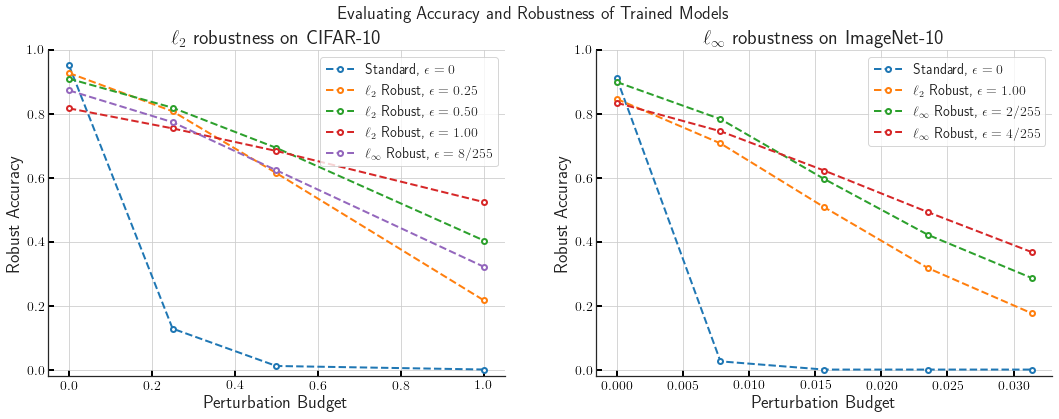

In [8]:
fig, axs = plt.subplots(1,2,figsize=(18,6))

labels = {
    'std': r'Standard, $\epsilon=0$',
    'l2-0.25': r'$\ell_2$ Robust, $\epsilon=0.25$',
    'l2-0.50': r'$\ell_2$ Robust, $\epsilon=0.50$',
    'l2-1.00': r'$\ell_2$ Robust, $\epsilon=1.00$',
    'l2-1': r'$\ell_2$ Robust, $\epsilon=1.00$',
    'linf-8': r'$\ell_{\infty}$ Robust, $\epsilon=8/255$',
    'linf4': r'$\ell_{\infty}$ Robust, $\epsilon=4/255$',
    'linf2': r'$\ell_{\infty}$ Robust, $\epsilon=2/255$',
}

titles = {
    'cifar': '$\ell_2$ robustness on CIFAR-10',
    'imagenet': '$\ell_{\infty}$ robustness on ImageNet-10'
}

for ax, dset in zip(axs, ['cifar', 'imagenet']):
    accs = accuracies[dset]
    for mname, maccs in accs.items():
        x, y = map(np.array, zip(*sorted(maccs.items())))
        ax.plot(x, y, marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--', label=labels[mname])
    utils.update_ax(ax, titles[dset], r'Perturbation Budget', r'Robust Accuracy', ticks_fs=14, label_fs=18, title_fs=20); ax.grid()
    ax.legend(loc='upper right', ncol=1, fontsize=14, frameon=True, fancybox=True)
    ax.set_ylim(-0.02,1)

sup = fig.suptitle('Evaluating Accuracy and Robustness of Trained Models', fontsize=18)
fig.savefig('plots/cifar10_imagenet10_robustness.pdf', dpi=fig.dpi, bbox_inches='tight', bbox_extra_artists=[sup])

The subplots above serve as sanity checks to show that (i) adversarially training models using $\ell_2$ and $\ell_{\infty}$ perturbations confers adversarial robustness at test time (relative to standard models trained on original data) and (ii) increasing the perturbation budget $\epsilon$ improves adversarial robustness for larger values of $\epsilon$.

## Evaluating Attribution Quality $\text{AQ}(\mathcal{A}_{\mathcal{G}}, k)$
In this section, we evaluate the accuracies of models trained on top-$k$ and bottom-$k$ attribution-masked data for multiple values of level $k$ to estimate the quality of gradient based attributions. For more information about our evaluation framework and metric $\text{AQ}(\mathcal{A}_{\mathcal{G}}, k)$, please check out Section 3 of our paper. To know more about retraining models on masked datasets, check out the README files.

### Processing Retrained Models' Performance on Masked Test Data

In [9]:
"""
Parse performance of standard and robust models
retrained on attribution-masked CIFAR-10 and ImageNet-10 data.
"""
tracker = utils.NestedDict()

all_paths_fpath = os.path.join(DATA_DIR, 'all.json')
with open(all_paths_fpath, 'rb') as f: 
    all_paths = json.load(f)

for dname, dd in all_paths.items():
    print (f'Parsing {dname}-10 models')
    for mname, md in dd.items():
        if mname in ['logit']: continue 
        print (f'  {mname} models')

        for mtype, fname_list in md.items():
            print (f'\ttrained on {mtype}-k masked data')
            counter = 0

            for idx, fname in enumerate(fname_list):
                if not fname: continue
                fpath = os.path.join(DATA_DIR, 'trackers', fname)
                d = torch.load(fpath)

                for run_idx, (rname, ed) in enumerate(d.items()):
                    print (f"\t  run {counter}, masking fractions:", end=' ')
                    counter += 1
                    for eps, _epath in ed.items():
                        efile = _epath.rsplit('/', 1)[-1]
                        epath = os.path.join(DATA_DIR, 'retrained', efile)
                        if not os.path.exists(epath): continue
                        print (eps, end=', ')
                            

                        acc =  torch.load(epath)['stats']['best_model'][0]
                        tracker[dname][mname][rname][eps][idx][mtype] = acc
                    print()

Parsing cifar-10 models
  standard models
	trained on top-k masked data
	  run 0, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 1, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 2, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	trained on bottom-k masked data
	  run 0, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 1, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 2, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
  linf-8 models
	trained on top-k masked data
	  run 0, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 1, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	trained on bottom-k masked data
	  run 0, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
	  run 1, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 
  l2-0.25 models
	trained on bottom-k masked data
	  run 0, masking fractions: 0.0, 0.1, 0.3, 0.5, 0.7, 0.

In [10]:
"""
Preprocess data for plots 
- Flatten statistics across runs
- Aggregate into mean and standard deviation
"""

# flatten across runs
flat_tracker = utils.NestedDict()
all_diffs = utils.NestedDict()

for (dname, model_type, run_name, eps), all_accs in dict(utils.traverse_nested_dict(tracker, depth=3)).items():
    tops = [v['top'] for k,v in all_accs.items()]
    btms = [v['bottom'] for k,v in all_accs.items()]
    
    diffs = []
    for v1 in tops:
        for v2 in btms:
            diffs.append(v2-v1)
            
    flat_tracker[dname][model_type][run_name][eps] = diffs        
    
# compute mean and standard deviation 
for dname, mtd in flat_tracker.items():
    for model_type, rund in mtd.items():
        X, Y = [], []
        diffs = defaultdict(list)
        for run_name, epsd in rund.items():
            x, y = [], []
            for mf, accs in epsd.items():
                x.append(mf)
                y.append(np.mean(accs))               
                for a in accs: diffs[mf].append(a)
                    
            x, y = map(np.array, [x, y])
            X.append(1-np.array(x))
            Y.append(y)
            
        x, m, s = [], [], []        
        for mf, d in diffs.items():
            x.append(1-mf)
            m.append(np.mean(d))
            s.append(np.std(d))
            
        all_diffs[dname][model_type] = (x, m, s)

### Input Gradients of ResNet50 trained on CIFAR-10

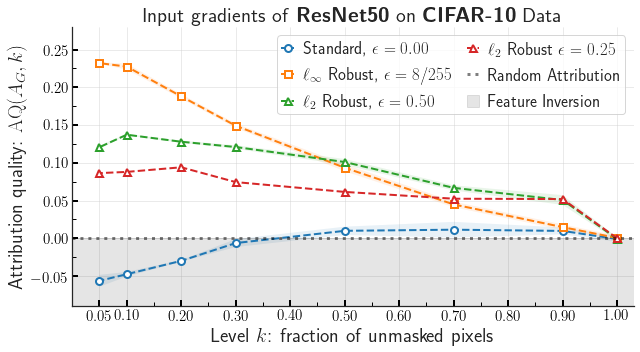

In [12]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
ax = mu.plot_gradient_quality_real_data(all_diffs, 'cifar', ax)
fig.tight_layout()
fig.savefig('plots/feature_inversion_cifar10.pdf')

### Input Gradients of ResNet18 trained on ImageNet-10

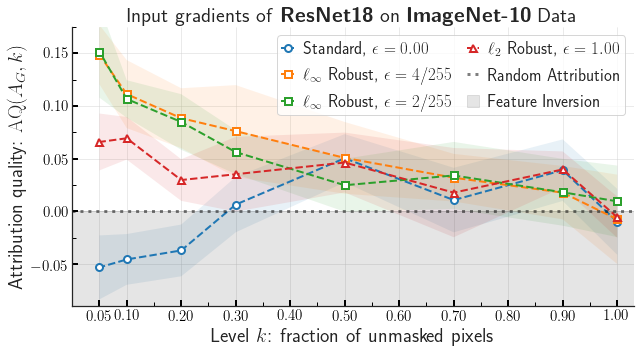

In [14]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
ax = mu.plot_gradient_quality_real_data(all_diffs, 'imagenet', ax)
fig.tight_layout()
fig.savefig('plots/feature_inversion_imagenet10.pdf')

Standard ResNet18 and ResNet50 models trained on CIFAR-10 and ImageNet-10 exhibit FIG and RF-FIG: 

- **FIG** (Feature Inversion in Gradients): The shaded area in the figures illustrates that when level $k$ < 20%, attribution quality $\text{AQ}(\mathcal{A}_{\mathcal{G}}, k)$ is consistently negative. As discussed in Section 3 of the paper, the plots above indicate that input gradients of standard models violate premise (P), as the features with lowest gradient magnitude have more predictive power of the labels than the features with highest gradient magnitude. In other words, contrary to conventional wisdom, input gradients highlight irrelevant features and suppress relevant features in benchmark image classiﬁcation tasks. 
- **RF-FIG** (Robustness fixes FIG): Adversarially trained models exhibit input gradients with consistently positive attribution quality $\text{AQ}(\mathcal{A}_{\mathcal{G}}, k)$. That is, models that are adversarially trained fix feature inversion in gradients (FIG) on both datasets.